# Import Libraries

In [ ]:
pip install pydub SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 27.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
import os
import pickle
import joblib
import librosa

In [ ]:
import pydub as pyd
import IPython.display as ipd
import speech_recognition as sprg

# Import Models

## Speech Emotion Recognition Model

In [ ]:
json_file = open('./model/cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [ ]:
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("./model/model_weights.h5")

In [ ]:
with open('./model/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('./model/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)

# 1. Convert Input Audio to WAV Format

In [ ]:
input_path = "./sample_data/test.mp3"
output_path = "./sameple_data/test_output.wav"

In [ ]:
def convert_to_wav(input_path, output_path):
    # Check if the input file is already an MP3 file
    if input_path.lower().endswith('.wav'):
        # Copy the MP3 file to the output location
        os.system(f'cp "{input_path}" "{output_path}"')
    else:
        # Load the input audio file
        audio = pyd.AudioSegment.from_file(input_path)

        # Convert to MP3 format
        audio.export(output_path, format="wav")

In [ ]:
convert_to_wav(input_path, output_path)

# 2. Audio file Analysis

In [ ]:
# Load audio data
audio_data, audio_sr = librosa.load(output_path)

# Audio
ipd.Audio(audio_data, rate=audio_sr)

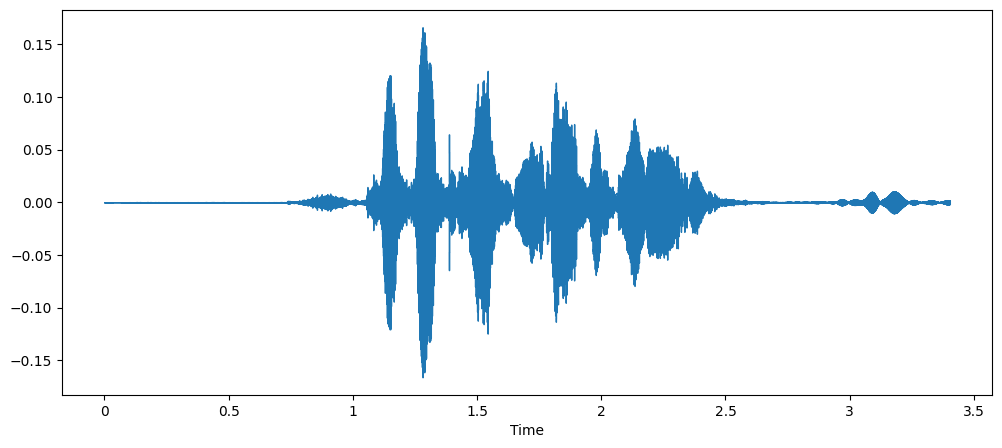

In [ ]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=audio_data, sr=audio_sr);

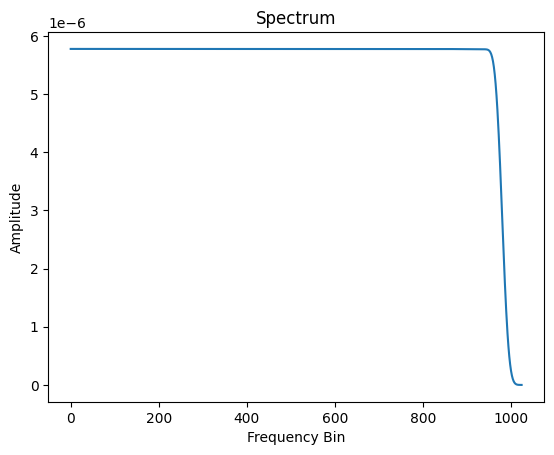

In [ ]:
n_fft = 2048
D = np.abs(librosa.stft(audio_data[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');
plt.plot(D);

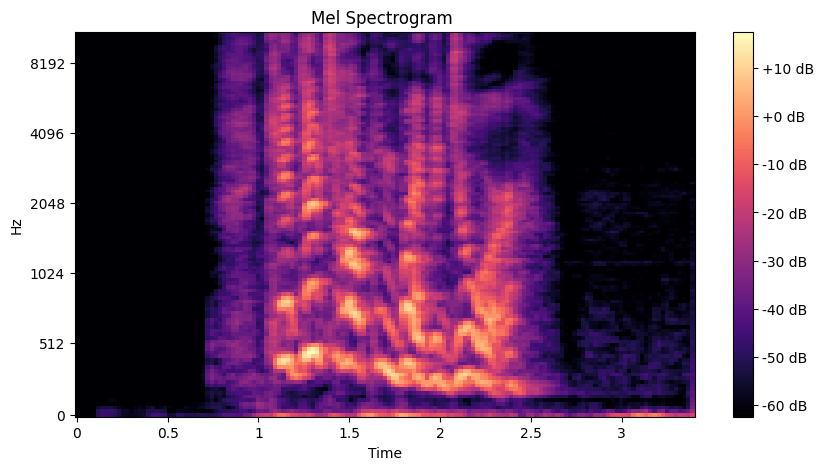

In [ ]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=audio_sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=audio_sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

# 3.  Transcript the Audio

In [ ]:
transcriptions = []

# Recognize text from PCM audio
recognizer = sprg.Recognizer()

with sprg.AudioFile(output_path) as source:
    sprg_audio_data = recognizer.record(source)
    detected_text = recognizer.recognize_google(sprg_audio_data)
    transcriptions.append({"detected_text": detected_text})

print(transcriptions)

[{'detected_text': 'kids are talking by the door'}]


In [ ]:
# Function
def predict_emotions(docx):
    results = pipe_lr.predict([docx])
    return results[0]

def get_prediction_proba(docx):
    results = pipe_lr.predict_proba([docx])
    return results

In [ ]:
def text_emotion_detection(raw_text):
    prediction = predict_emotions(raw_text)
    probability = get_prediction_proba(raw_text)

    results = []
    for label, conf in zip(pipe_lr.classes_, probability[0]):
        results.append({'label': label, 'confidence': conf})

    results = sorted(results, key=lambda x: x['confidence'], reverse=True)

    return results

In [ ]:
input_sentence = '''
look out I've tried everything it's writing different features turning the hyperparameters in the mall and stuff what else I can do it just won't go up
'''

In [ ]:
result = text_emotion_detection(input_sentence)

# result = text_emotion_detection(detected_text)

print("Predicted Emotions and Confidences:", f"{result[0]['label']}, {result[0]['confidence']}\n")

result

Predicted Emotions and Confidences: joy, 0.3320305697298583



[{'label': 'joy', 'confidence': 0.3320305697298583},
 {'label': 'anger', 'confidence': 0.2876919557644892},
 {'label': 'sadness', 'confidence': 0.17630204995950438},
 {'label': 'fear', 'confidence': 0.16217322125923914},
 {'label': 'surprise', 'confidence': 0.025130912735272248},
 {'label': 'disgust', 'confidence': 0.016560159400209253},
 {'label': 'shame', 'confidence': 0.00010642099393397033},
 {'label': 'neutral', 'confidence': 4.710157493596862e-06}]

# 4. Speech Emotion Recognition Module

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((
      result,
      zcr(data,frame_length,hop_length),
      rmse(data,frame_length,hop_length),
      mfcc(data,sr,frame_length,hop_length)
    ))

    return result

In [ ]:
def get_predict_feat(path, expected_shape=(1, 2376)):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)

    # Ensure res is reshaped or padded to match the expected shape
    if res.shape != expected_shape:
        flat_size = np.prod(expected_shape)
        if res.size < flat_size:
            # Pad if the size is smaller than expected
            pad_width = (0, flat_size - res.size)
            res = np.pad(res, pad_width=pad_width, mode='constant')
        else:
            # Resize if the size is larger than expected
            res = np.resize(res, expected_shape)

    i_result = scaler.transform(res.reshape(1, -1))
    final_result = np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = loaded_model.predict(res)

    # Get the label names or define them if available
    label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral_Calm', 'Sad', 'Surprise']

    # Get the index of the label with the highest confidence score
    predicted_label_index = np.argmax(predictions)

    # List to store confidence scores
    confidence_scores = []

    # Display predicted emotion and confidence for each label
    print(f"Predicted Emotion: {label_names[predicted_label_index]}")
    for label_index, label_name in enumerate(label_names):
        confidence_score = predictions[0][label_index]
        confidence_score = 0 if confidence_score < 0.001 else confidence_score
        # formatted_confidence = float(f"{confidence_score:.10f}")
        print(f"{label_name}: {confidence_score}")
        confidence_scores.append({'label': label_name, 'confidence': confidence_score})

    print("\n")

    sorted_confidence_scores = sorted(confidence_scores, key=lambda x: x['confidence'], reverse=True)

    return sorted_confidence_scores

In [ ]:
prediction(output_path)

1/1 [==============================] - 1s 567ms/step
Predicted Emotion: Fear
Angry: 0
Disgust: 0
Fear: 1.0
Happy: 0
Neutral_Calm: 0
Sad: 0
Surprise: 0




[{'label': 'Fear', 'confidence': 1.0},
 {'label': 'Angry', 'confidence': 0},
 {'label': 'Disgust', 'confidence': 0},
 {'label': 'Happy', 'confidence': 0},
 {'label': 'Neutral_Calm', 'confidence': 0},
 {'label': 'Sad', 'confidence': 0},
 {'label': 'Surprise', 'confidence': 0}]